In [1]:
# Load the required packages
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics, svm
from sklearn.model_selection import (
    train_test_split, learning_curve, StratifiedShuffleSplit, GridSearchCV,
    cross_val_score)

# Improve the readability of figures
sns.set_context('notebook', font_scale=1.4)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Load the dataset
df = pd.read_table('data/SMSSpamCollection.txt', header=None)

# Display the first five rows
df.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
0    5572 non-null object
1    5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


In [4]:
# Store the target variable
y = df[0]

# Display the class distribution
y.value_counts()

ham     4825
spam     747
Name: 0, dtype: int64

In [6]:
# Encode the class labels as numbers
le = LabelEncoder()
y_enc = le.fit_transform(y)

In [7]:
# Store the SMS message data
raw_text = df[1]

In [8]:
example = """  ***** CONGRATlations **** You won 2 tIckETs to Hamilton in 
NYC http://www.hamiltonbroadway.com/J?NaIOl/event   wORtH over $500.00...CALL 
555-477-8914 or send message to: hamilton@freetix.com to get ticket !! !  """

In [9]:
# Replace email addresses with 'emailaddr'
processed = raw_text.str.replace(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b',
                                 'emailaddr')

# Replace URLs with 'httpaddr'
processed = processed.str.replace(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)',
                                  'httpaddr')

# Replace money symbols with 'moneysymb'
processed = processed.str.replace(r'£|\$', 'moneysymb')
    
# Replace phone numbers with 'phonenumbr'
processed = processed.str.replace(
    r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b',
    'phonenumbr')
    
# Replace numbers with 'numbr'
processed = processed.str.replace(r'\d+(\.\d+)?', 'numbr')

In [10]:
# Remove punctuation
processed = processed.str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
processed = processed.str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
processed = processed.str.replace(r'^\s+|\s+?$', '')

In [11]:
# Lowercase the corpus
processed = processed.str.lower()

In [13]:
# Access stop words
stop_words = nltk.corpus.stopwords.words('english')

In [14]:
# Remove all stop words
processed = processed.apply(lambda x: ' '.join(
    term for term in x.split() if term not in set(stop_words))
)

In [16]:
# Remove word stems using a Porter stemmer
porter = nltk.PorterStemmer()
processed = processed.apply(lambda x: ' '.join(
    porter.stem(term) for term in x.split())
)

In [17]:
def preprocess_text(messy_string):
    assert(type(messy_string) == str)
    cleaned = re.sub(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr', messy_string)
    cleaned = re.sub(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr',
                     cleaned)
    cleaned = re.sub(r'£|\$', 'moneysymb', cleaned)
    cleaned = re.sub(
        r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b',
        'phonenumbr', cleaned)
    cleaned = re.sub(r'\d+(\.\d+)?', 'numbr', cleaned)
    cleaned = re.sub(r'[^\w\d\s]', ' ', cleaned)
    cleaned = re.sub(r'\s+', ' ', cleaned)
    cleaned = re.sub(r'^\s+|\s+?$', '', cleaned.lower())
    return ' '.join(
        porter.stem(term) 
        for term in cleaned.split()
        if term not in set(stop_words)
    )

In [18]:
(processed == raw_text.apply(preprocess_text)).all()

False

Additionally, let's test `preprocess_text()` on the hypothethical SMS message from earlier.

In [19]:
preprocess_text(example)

'congratl numbr ticket hamilton nyc httpaddr worth moneysymbnumbr call phonenumbr send messag emailaddr get ticket'

In [20]:
# Construct a design matrix using an n-gram model and a tf-idf statistics
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_ngrams = vectorizer.fit_transform(processed)

In [21]:
X_ngrams.shape

(5572, 36323)

In [22]:
# Prepare the training and test sets using an 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X_ngrams,
    y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)

# Train SVM with a linear kernel on the training set
clf = svm.LinearSVC(loss='hinge')
clf.fit(X_train, y_train)

# Evaluate the classifier on the test set
y_pred = clf.predict(X_test)

# Compute the F1 score
metrics.f1_score(y_test, y_pred)

0.9285714285714286

In [23]:
# Display a confusion matrix
pd.DataFrame(
    metrics.confusion_matrix(y_test, y_pred),
    index=[['actual', 'actual'], ['spam', 'ham']],
    columns=[['predicted', 'predicted'], ['spam', 'ham']]
)

predicted     
                 spam  ham
actual spam       965    1
       ham         19  130

In [24]:
# Select 10 different sizes of the entire dataset
sample_space = np.linspace(500, len(raw_text) * 0.8, 10, dtype='int')

# Compute learning curves without regularization for the SVM model
train_sizes, train_scores, valid_scores = learning_curve(
    estimator=svm.LinearSVC(loss='hinge', C=1e10),
    X=X_ngrams,
    y=y_enc,
    train_sizes=sample_space,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=40),
    scoring='f1',
    n_jobs=-1
)

In [25]:
def make_tidy(sample_space, train_scores, valid_scores):
    # Join train_scores and valid_scores, and label with sample_space
    messy_format = pd.DataFrame(
        np.stack((sample_space, train_scores.mean(axis=1),
                  valid_scores.mean(axis=1)), axis=1),
        columns=['# of training examples', 'Training set', 'Validation set']
    )
    
    # Re-structure into tidy format
    return pd.melt(
        messy_format,
        id_vars='# of training examples',
        value_vars=['Training set', 'Validation set'],
        var_name='Scores',
        value_name='F1 score'
    )

C:\Users\Akash_Shrivastava\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


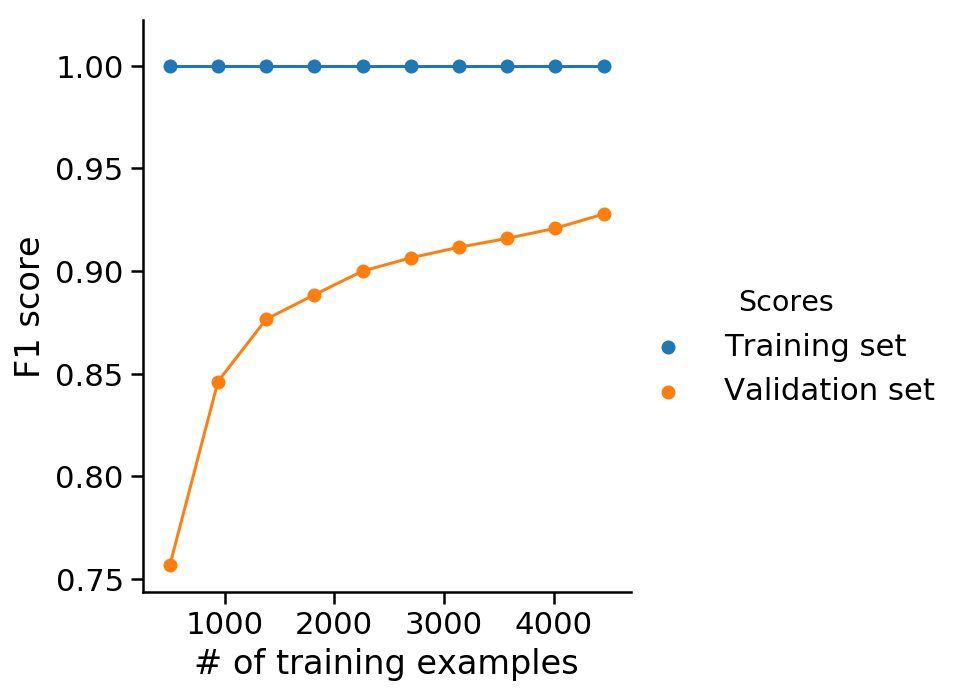

In [26]:
# Initialize a FacetGrid object using the table of scores and facet on
# the type of score
g = sns.FacetGrid(
    make_tidy(sample_space, train_scores, valid_scores), hue='Scores', size=5
)

# Plot the learning curves and add a legend
g.map(plt.scatter, '# of training examples', 'F1 score')
g.map(plt.plot, '# of training examples', 'F1 score').add_legend();

In [39]:
# Identify the optimal regularization hyperparameter
#GridSearchCV.fit(X_ngrams, y_enc)
param_grid = [{'C':np.logspace (-4,4,20)}]
grid_search = GridSearchCV (estimator=svm.LinearSVC(loss='hinge'), param_grid=param_grid)
grid_search.fit(X_ngrams, y_enc)

# Train the classifier on the entire dataset using the optimal hyperparameter
final_clf = svm.LinearSVC(loss='hinge', C=grid_search.best_params_['C'])
final_clf.fit(X_ngrams, y_enc);

In [40]:
# Display the features with the highest weights in the SVM model
pd.Series(
    final_clf.coef_.T.ravel(),
    index=vectorizer.get_feature_names()
).sort_values(ascending=False)[:20]

phonenumbr         5.005857
numbrp             2.798578
txt                2.692173
moneysymbnumbr     2.557628
call phonenumbr    2.251665
rington            2.098136
servic             2.045752
mobil              2.036778
numbr              1.895430
tone               1.831066
repli              1.665451
text               1.604178
claim              1.592876
video              1.473497
free               1.361441
wap                1.336300
stop               1.311168
credit             1.276876
uk                 1.238940
order              1.228048
dtype: float64

In [41]:
def spam_filter(message):
    if final_clf.predict(vectorizer.transform([preprocess_text(message)])):
        return 'spam'
    else:
        return 'not spam'

In [42]:
spam_filter(example)

'spam'

In [43]:
spam_filter('Ohhh, but those are the best kind of foods')

'not spam'